In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    top_k_accuracy_score
)
from keras import layers
from sklearn.model_selection import train_test_split

In [5]:
BASE_DIR = r"D:\New folder (3)"
IMG_DIR = os.path.join(BASE_DIR, "Test", "Test")
MODEL_PATH = os.path.join(BASE_DIR, "best_model1_1_checkpoint.keras")
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

In [6]:
labels_vi = {
    0: "Giới hạn tốc độ (20 km/h)", 1: "Giới hạn tốc độ (30 km/h)",
    2: "Giới hạn tốc độ (50 km/h)", 3: "Giới hạn tốc độ (60 km/h)",
    4: "Giới hạn tốc độ (70 km/h)", 5: "Giới hạn tốc độ (80 km/h)",
    6: "Hết giới hạn tốc độ (80 km/h)", 7: "Giới hạn tốc độ (100 km/h)",
    8: "Giới hạn tốc độ (120 km/h)", 9: "Cấm vượt",
    10: "Cấm xe tải > 3.5 tấn vượt", 11: "Đường ưu tiên",
    12: "Đường chính (ưu tiên)", 13: "Nhường đường",
    14: "Dừng lại", 15: "Cấm mọi phương tiện", 16: "Cấm xe tải > 3.5 tấn",
    17: "Cấm vào", 18: "Cảnh báo nguy hiểm", 19: "Khúc cua trái",
    20: "Khúc cua phải", 21: "Hai khúc cua liên tiếp",
    22: "Đường gập ghềnh", 23: "Đường trơn trượt",
    24: "Đường hẹp bên phải", 25: "Công trường phía trước",
    26: "Có đèn giao thông phía trước", 27: "Lối đi bộ phía trước",
    28: "Trẻ em qua đường", 29: "Đường xe đạp cắt ngang",
    30: "Nguy hiểm băng tuyết/đóng băng", 31: "Thú rừng qua đường",
    32: "Hết mọi giới hạn cấm", 33: "Bắt buộc rẽ phải",
    34: "Bắt buộc rẽ trái", 35: "Bắt buộc đi thẳng",
    36: "Đi thẳng hoặc rẽ phải", 37: "Đi thẳng hoặc rẽ trái",
    38: "Giữ bên phải", 39: "Giữ bên trái",
    40: "Vòng xuyến bắt buộc", 41: "Hết cấm vượt (xe con)",
    42: "Hết cấm vượt (xe tải)"
}

In [7]:
test_df = pd.read_csv(os.path.join(BASE_DIR, "Test.csv"))
test_df["Path"] = test_df["Path"].str.replace("Test/", "", regex=False)
test_df["ClassId_str"] = test_df["ClassId"].astype(str)

In [9]:
unique_labels = sorted(test_df["ClassId_str"].unique())
num_classes = len(unique_labels)

reverse_map = {i: int(unique_labels[i]) for i in range(num_classes)}

keys_tensor = tf.constant(unique_labels)
vals_tensor = tf.constant(list(range(num_classes)))
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1
)

In [10]:
def load_and_preprocess_img(path, label, base_dir):
    full_path = tf.strings.join([base_dir, "/", path])
    img = tf.io.read_file(full_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    label_id = table.lookup(label)
    label_onehot = tf.one_hot(label_id, num_classes)
    return img, label_onehot

In [11]:
def make_dataset(df, base_dir):
    ds = tf.data.Dataset.from_tensor_slices((df["Path"].values, df["ClassId_str"].values))
    ds = ds.map(lambda x, y: load_and_preprocess_img(x, y, base_dir),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
test_gen = make_dataset(test_df, IMG_DIR)

In [13]:
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded thành công!")

Model loaded thành công!


In [14]:
preds = model.predict(test_gen)
y_pred_raw = np.argmax(preds, axis=1)
y_pred_true = np.array([reverse_map[i] for i in y_pred_raw])
y_true = test_df["ClassId"].astype(int).values

395/395 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step


In [15]:
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_true, digits=3))



--- Classification Report ---
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        60
           1      0.999     0.979     0.989       720
           2      1.000     0.975     0.987       750
           3      0.969     0.969     0.969       450
           4      0.991     0.983     0.987       660
           5      0.964     0.965     0.964       630
           6      0.833     0.767     0.799       150
           7      0.984     0.929     0.955       450
           8      0.877     0.998     0.933       450
           9      0.998     0.985     0.992       480
          10      0.986     0.991     0.989       660
          11      0.952     0.990     0.971       420
          12      0.946     0.919     0.932       690
          13      0.925     1.000     0.961       720
          14      1.000     0.993     0.996       270
          15      0.958     0.981     0.969       210
          16      0.980     1.000     0.990       

In [16]:
acc = accuracy_score(y_true, y_pred_true)

y_true_idx = np.array([list(reverse_map.values()).index(x) for x in y_true])
top3_acc = top_k_accuracy_score(y_true_idx, preds, k=3)

print("\n--- Kết quả tổng hợp ---")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")


--- Kết quả tổng hợp ---
Accuracy: 96.52%
Top-3 Accuracy: 98.81%


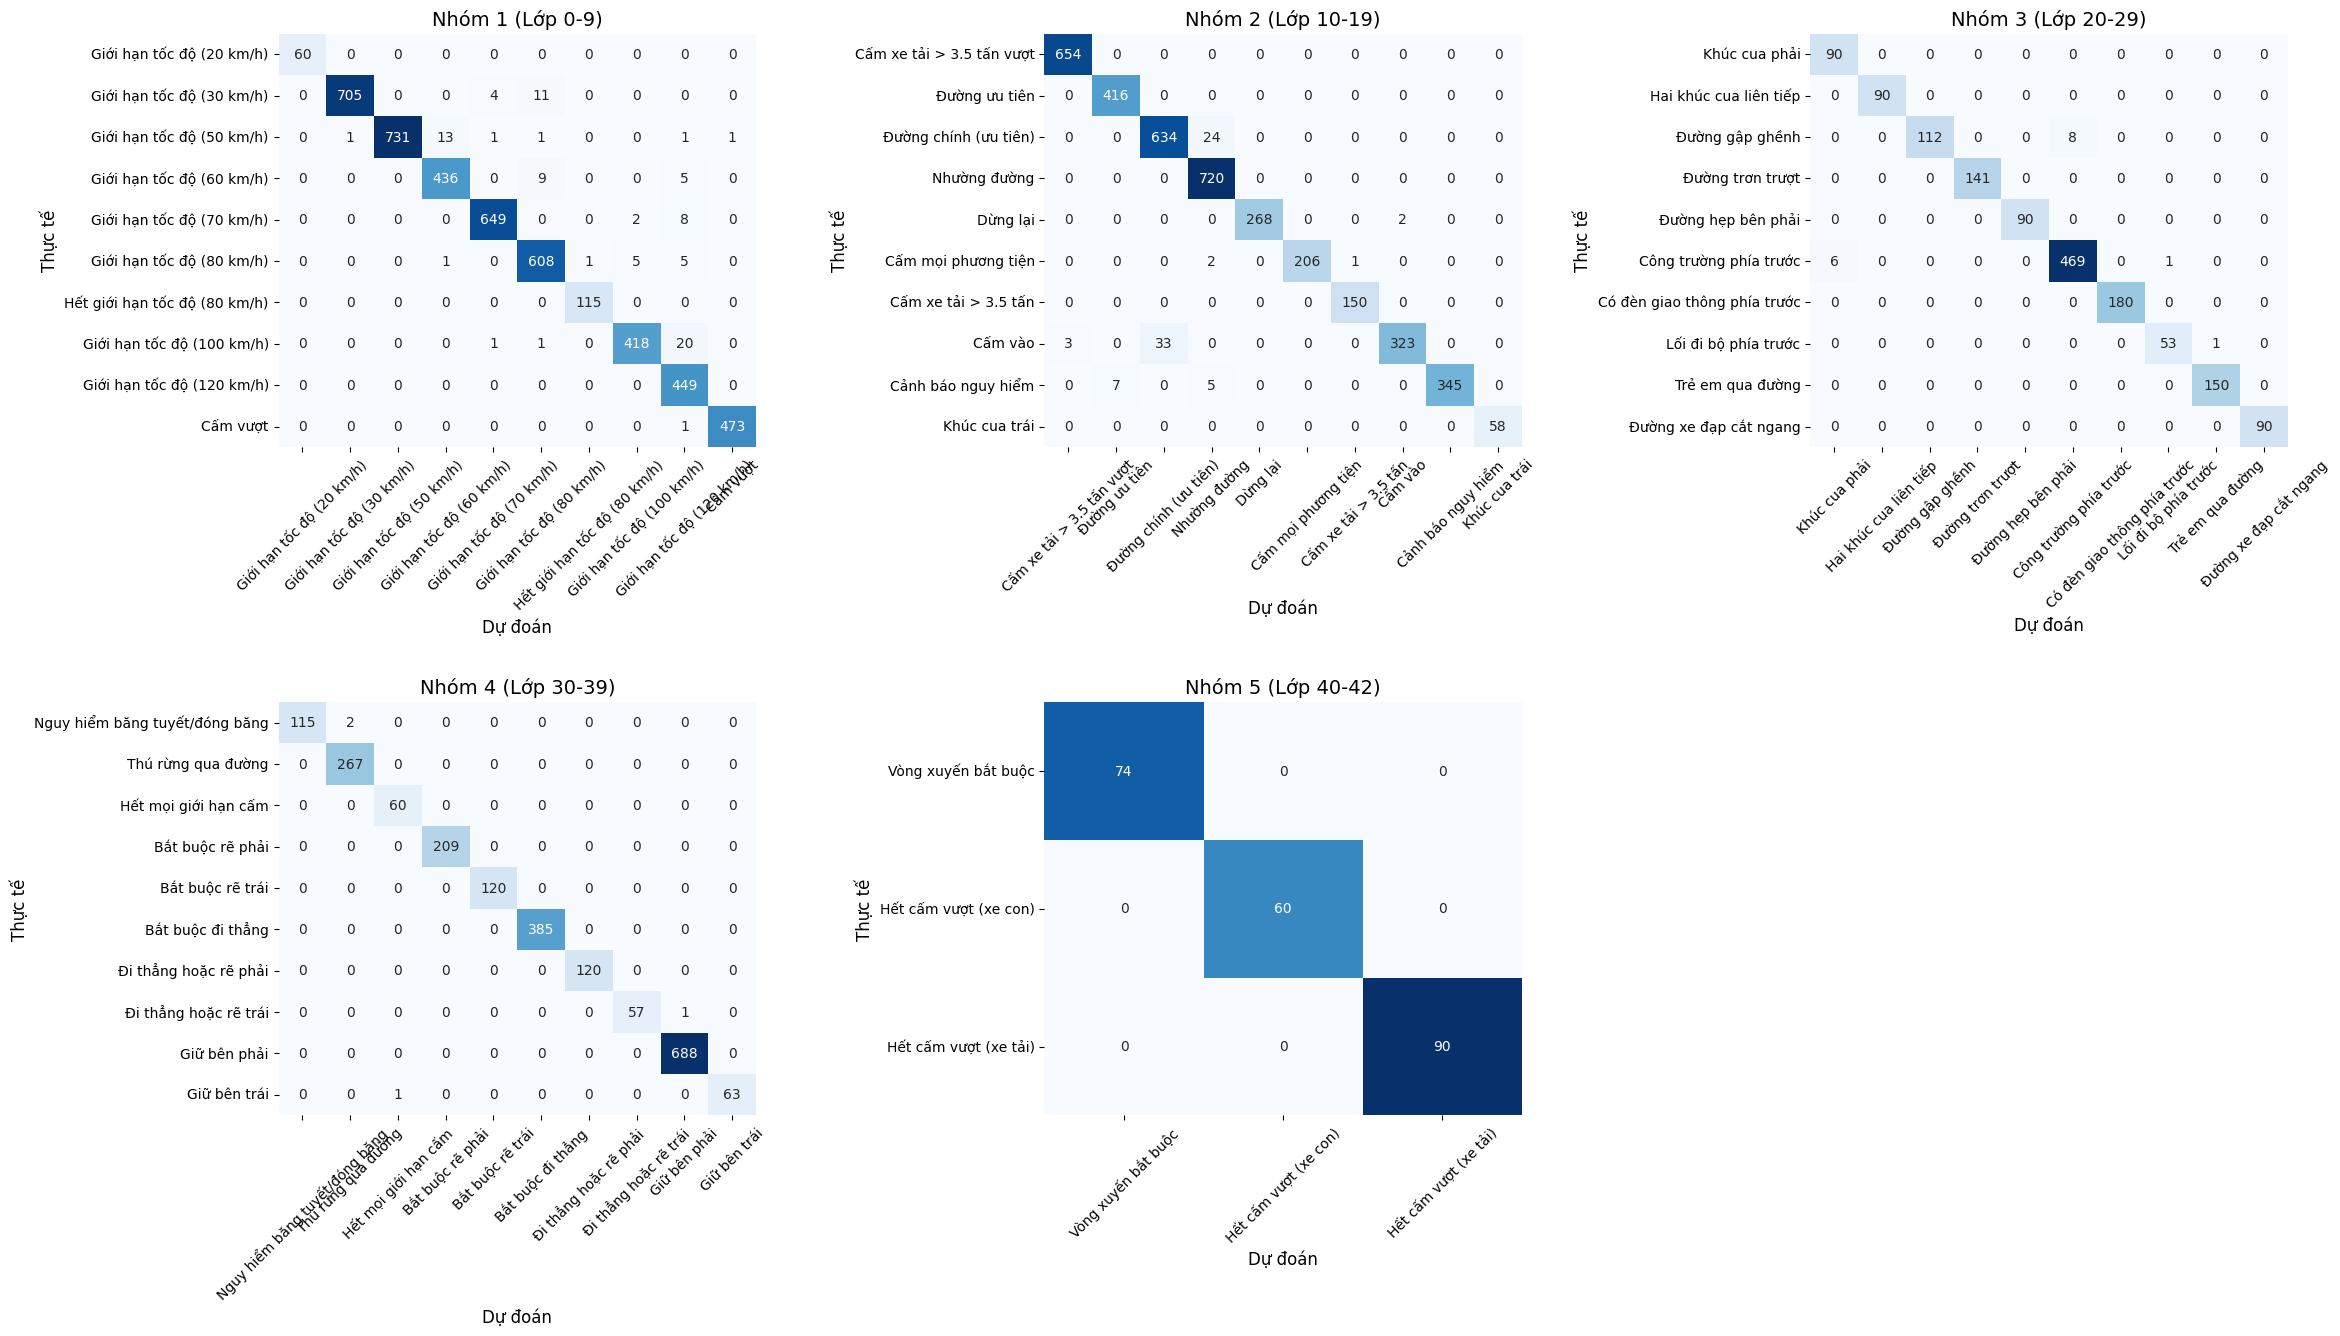

In [22]:
cm = confusion_matrix(y_true, y_pred_true)

classes = list(labels_vi.keys())
class_names = [labels_vi[i] for i in classes]
num_classes = len(classes)
group_size = 10
num_groups = (num_classes + group_size - 1) // group_size  

groups_per_figure = 6
rows, cols = 2, 3

for fig_start in range(0, num_groups, groups_per_figure):
    fig_end = min(fig_start + groups_per_figure, num_groups)
    # Tăng figsize, mỗi subplot rộng hơn
    fig, axes = plt.subplots(rows, cols, figsize=(24, 14))
    axes = axes.flatten()

    for idx, g in enumerate(range(fig_start, fig_end)):
        start = g * group_size
        end = min(start + group_size, num_classes)
        subset = range(start, end)
        cm_subset = cm[np.ix_(subset, subset)]
        labels_subset = [class_names[i] for i in subset]

        sns.heatmap(cm_subset, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels_subset, yticklabels=labels_subset,
                    ax=axes[idx], cbar=False)
        axes[idx].set_title(f"Nhóm {g+1} (Lớp {start}-{end-1})", fontsize=14)
        axes[idx].set_xlabel("Dự đoán", fontsize=12)
        axes[idx].set_ylabel("Thực tế", fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=10)
        axes[idx].tick_params(axis='y', rotation=0, labelsize=10)

    # Ẩn các subplot thừa nếu có
    for j in range(idx + 1, rows * cols):
        axes[j].axis('off')

    # Tăng khoảng cách giữa các subplot để tránh đè chữ
    plt.tight_layout(pad=3.0)
    plt.show()

In [23]:
#  TOP 10 LỖI PHỔ BIẾN 
errors = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            errors.append((i, j, cm[i, j]))
errors = sorted(errors, key=lambda x: x[2], reverse=True)[:10]

print("\n Top 10 lỗi nhầm lẫn phổ biến:")
for i, j, count in errors:
    print(f"- Thật: {labels_vi[i]}  →  Dự đoán: {labels_vi[j]}  ({count} lần)")


 Top 10 lỗi nhầm lẫn phổ biến:
- Thật: Cấm vào  →  Dự đoán: Đường chính (ưu tiên)  (33 lần)
- Thật: Hết giới hạn tốc độ (80 km/h)  →  Dự đoán: Hết cấm vượt (xe tải)  (32 lần)
- Thật: Đường chính (ưu tiên)  →  Dự đoán: Nhường đường  (24 lần)
- Thật: Giới hạn tốc độ (100 km/h)  →  Dự đoán: Giới hạn tốc độ (120 km/h)  (20 lần)
- Thật: Nguy hiểm băng tuyết/đóng băng  →  Dự đoán: Đường trơn trượt  (17 lần)
- Thật: Giữ bên trái  →  Dự đoán: Nhường đường  (16 lần)
- Thật: Đường chính (ưu tiên)  →  Dự đoán: Giới hạn tốc độ (120 km/h)  (15 lần)
- Thật: Vòng xuyến bắt buộc  →  Dự đoán: Hết giới hạn tốc độ (80 km/h)  (14 lần)
- Thật: Giới hạn tốc độ (50 km/h)  →  Dự đoán: Giới hạn tốc độ (60 km/h)  (13 lần)
- Thật: Giới hạn tốc độ (30 km/h)  →  Dự đoán: Giới hạn tốc độ (80 km/h)  (11 lần)


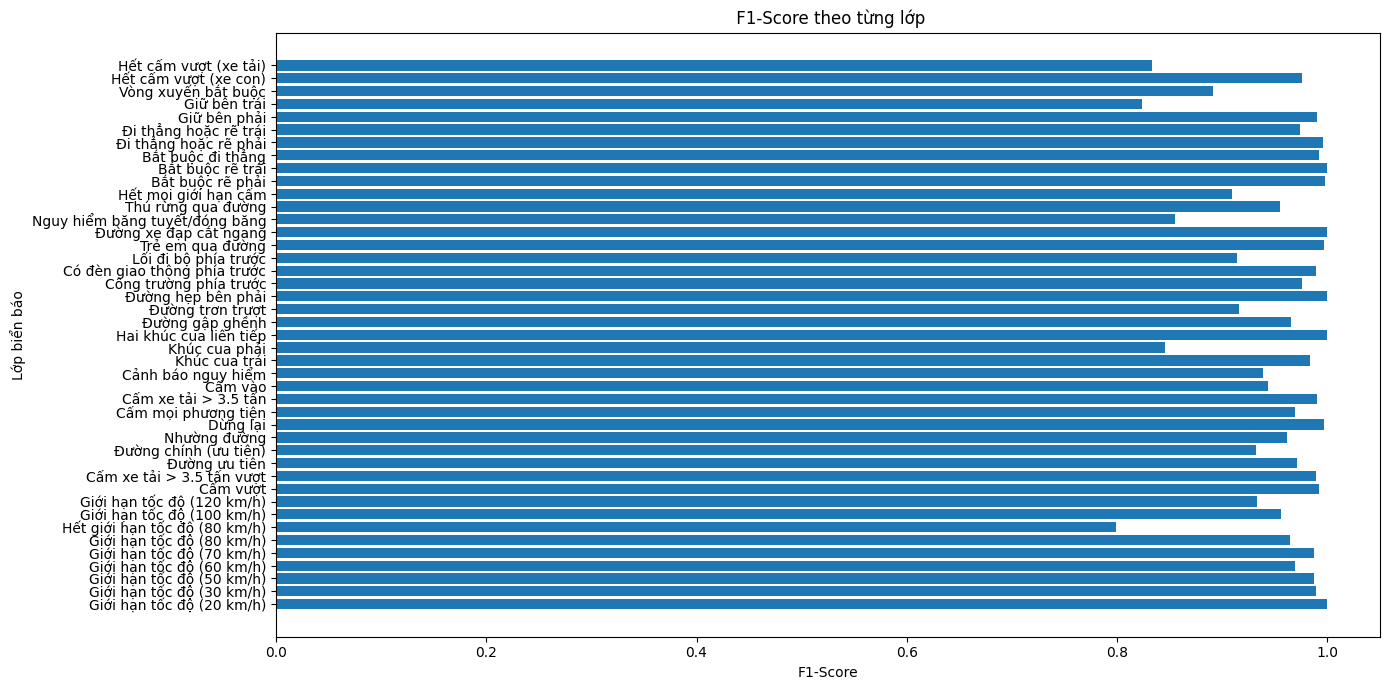

In [24]:
#  F1-SCORE THEO LỚP 
precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
    y_true, y_pred_true, labels=list(labels_vi.keys())
)
f1_df = pd.DataFrame({
    "ClassID": list(labels_vi.keys()),
    "Label": [labels_vi[i] for i in labels_vi.keys()],
    "F1": f1_cls,
})

plt.figure(figsize=(14, 7))
plt.barh(f1_df["Label"], f1_df["F1"])
plt.title(" F1-Score theo từng lớp")
plt.xlabel("F1-Score")
plt.ylabel("Lớp biển báo")
plt.tight_layout()
plt.show()

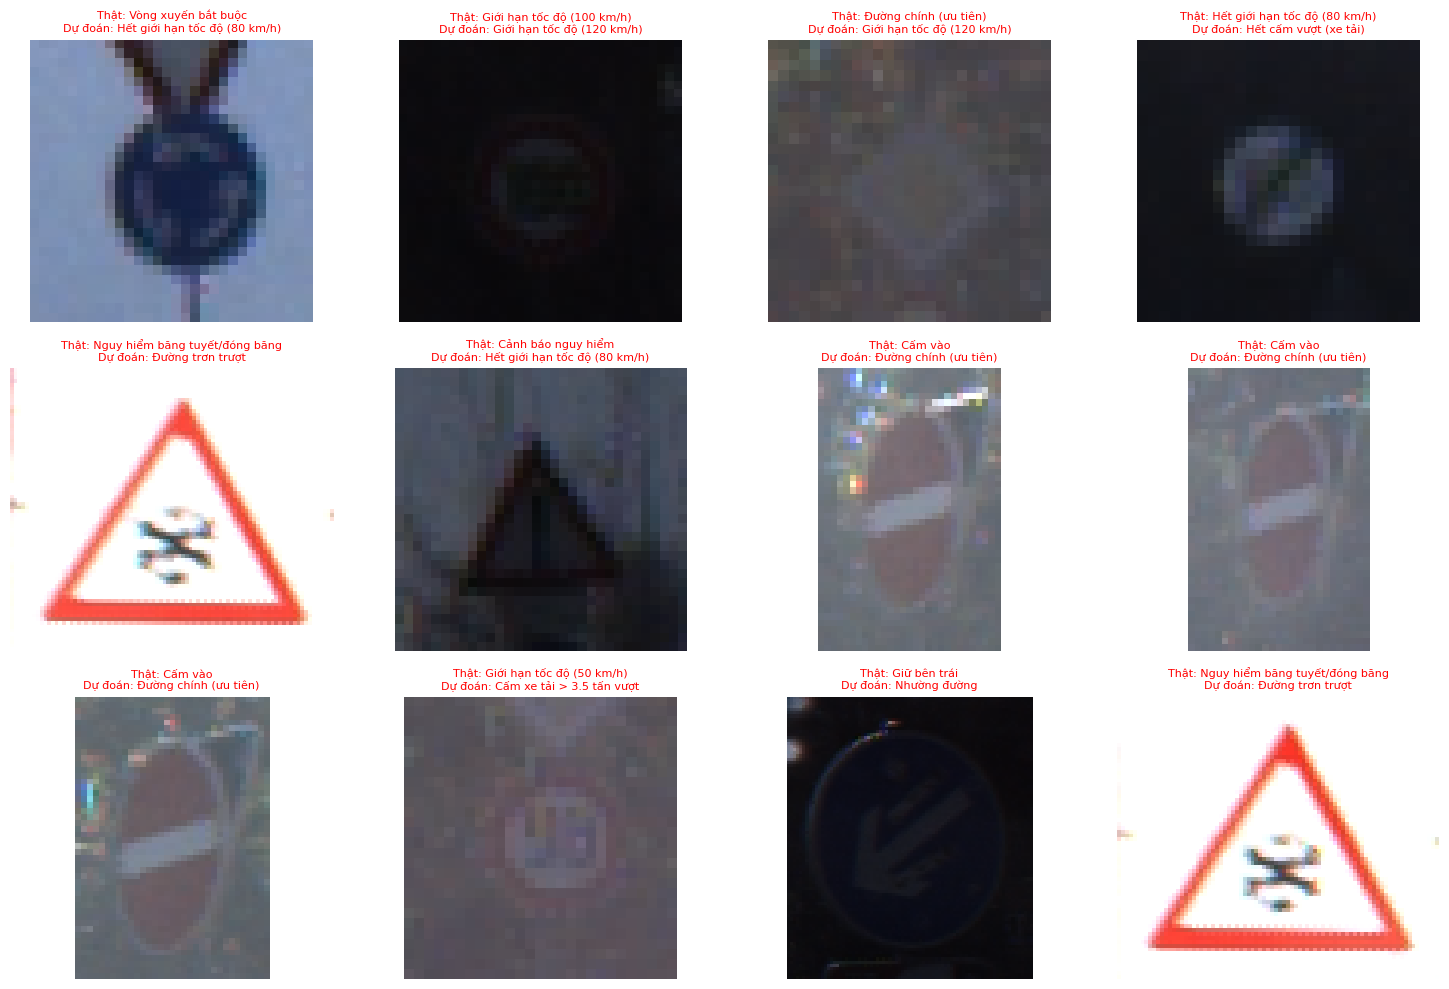

In [25]:
#  HIỂN THỊ ẢNH DỰ ĐOÁN SAI 
wrong_idx = np.where(y_true != y_pred_true)[0]
sample_wrong = random.sample(list(wrong_idx), min(12, len(wrong_idx)))

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_wrong):
    path = os.path.join(IMG_DIR, test_df.iloc[idx]["Path"])
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    true_label = labels_vi.get(y_true[idx], f"ID {y_true[idx]}")
    pred_label = labels_vi.get(y_pred_true[idx], f"ID {y_pred_true[idx]}")
    plt.title(f"Thật: {true_label}\nDự đoán: {pred_label}", fontsize=8, color="red")
plt.tight_layout()
plt.show()

In [31]:
import re
import matplotlib.pyplot as plt

# RAW LOG
log_text = r"""
Epoch 1: val_loss improved from None to 1.95716, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 451s 403ms/step - accuracy: 0.2159 - loss: 3.5564 - val_accuracy: 0.4194 - val_loss: 1.9572 - learning_rate: 0.0010
Epoch 2/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4619 - loss: 1.9460  
Epoch 2: val_loss improved from 1.95716 to 0.95073, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 415s 415ms/step - accuracy: 0.5460 - loss: 1.6002 - val_accuracy: 0.6946 - val_loss: 0.9507 - learning_rate: 0.0010
Epoch 3/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7285 - loss: 0.8952  
Epoch 3: val_loss improved from 0.95073 to 0.56583, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 421s 421ms/step - accuracy: 0.7714 - loss: 0.7440 - val_accuracy: 0.7910 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 4/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8474 - loss: 0.4839  
Epoch 4: val_loss improved from 0.56583 to 0.28852, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 435s 436ms/step - accuracy: 0.8627 - loss: 0.4432 - val_accuracy: 0.9194 - val_loss: 0.2885 - learning_rate: 0.0010
Epoch 5/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8973 - loss: 0.3374  
Epoch 5: val_loss improved from 0.28852 to 0.13759, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 391s 391ms/step - accuracy: 0.9005 - loss: 0.3284 - val_accuracy: 0.9546 - val_loss: 0.1376 - learning_rate: 0.0010
Epoch 6/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9230 - loss: 0.2479  
Epoch 6: val_loss improved from 0.13759 to 0.09687, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 397s 397ms/step - accuracy: 0.9248 - loss: 0.2422 - val_accuracy: 0.9671 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 7/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9368 - loss: 0.2135  
Epoch 7: val_loss improved from 0.09687 to 0.08257, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 429s 430ms/step - accuracy: 0.9369 - loss: 0.2088 - val_accuracy: 0.9760 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 8/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9413 - loss: 0.1893  
Epoch 8: val_loss improved from 0.08257 to 0.05687, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 406s 406ms/step - accuracy: 0.9416 - loss: 0.1872 - val_accuracy: 0.9811 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 9/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9472 - loss: 0.1773  
Epoch 9: val_loss did not improve from 0.05687
981/981 ━━━━━━━━━━━━━━━━━━━━ 488s 490ms/step - accuracy: 0.9477 - loss: 0.1737 - val_accuracy: 0.9836 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 10/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9503 - loss: 0.1724  
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_loss did not improve from 0.05687
981/981 ━━━━━━━━━━━━━━━━━━━━ 472s 473ms/step - accuracy: 0.9518 - loss: 0.1629 - val_accuracy: 0.9756 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 11/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9640 - loss: 0.1165  
Epoch 11: val_loss improved from 0.05687 to 0.02101, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 474s 475ms/step - accuracy: 0.9682 - loss: 0.0995 - val_accuracy: 0.9941 - val_loss: 0.0210 - learning_rate: 2.0000e-04
Epoch 12/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9723 - loss: 0.0879  
Epoch 12: val_loss improved from 0.02101 to 0.01922, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 453s 453ms/step - accuracy: 0.9741 - loss: 0.0789 - val_accuracy: 0.9940 - val_loss: 0.0192 - learning_rate: 2.0000e-04
Epoch 13/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9791 - loss: 0.0622  
Epoch 13: val_loss improved from 0.01922 to 0.01415, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 516s 519ms/step - accuracy: 0.9786 - loss: 0.0631 - val_accuracy: 0.9955 - val_loss: 0.0141 - learning_rate: 2.0000e-04
Epoch 14/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9787 - loss: 0.0603   
Epoch 14: val_loss did not improve from 0.01415
981/981 ━━━━━━━━━━━━━━━━━━━━ 589s 590ms/step - accuracy: 0.9794 - loss: 0.0605 - val_accuracy: 0.9945 - val_loss: 0.0183 - learning_rate: 2.0000e-04
Epoch 15/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9778 - loss: 0.0627  
Epoch 15: val_loss improved from 0.01415 to 0.01224, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 486s 487ms/step - accuracy: 0.9790 - loss: 0.0612 - val_accuracy: 0.9957 - val_loss: 0.0122 - learning_rate: 2.0000e-04
Epoch 16/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9814 - loss: 0.0577  
Epoch 16: val_loss improved from 0.01224 to 0.01047, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 511s 512ms/step - accuracy: 0.9811 - loss: 0.0574 - val_accuracy: 0.9969 - val_loss: 0.0105 - learning_rate: 2.0000e-04
Epoch 17/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9817 - loss: 0.0489   
Epoch 17: val_loss did not improve from 0.01047
981/981 ━━━━━━━━━━━━━━━━━━━━ 467s 467ms/step - accuracy: 0.9824 - loss: 0.0498 - val_accuracy: 0.9960 - val_loss: 0.0111 - learning_rate: 2.0000e-04
Epoch 18/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9825 - loss: 0.0547  
Epoch 18: val_loss improved from 0.01047 to 0.00952, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 471s 472ms/step - accuracy: 0.9832 - loss: 0.0500 - val_accuracy: 0.9972 - val_loss: 0.0095 - learning_rate: 2.0000e-04
Epoch 19/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9814 - loss: 0.0586  
Epoch 19: val_loss improved from 0.00952 to 0.00907, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 433s 434ms/step - accuracy: 0.9817 - loss: 0.0540 - val_accuracy: 0.9973 - val_loss: 0.0091 - learning_rate: 2.0000e-04
Epoch 20/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9842 - loss: 0.0454  
Epoch 20: val_loss improved from 0.00907 to 0.00881, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 429s 429ms/step - accuracy: 0.9842 - loss: 0.0463 - val_accuracy: 0.9969 - val_loss: 0.0088 - learning_rate: 2.0000e-04
Epoch 21/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9861 - loss: 0.0422  
Epoch 21: val_loss did not improve from 0.00881
981/981 ━━━━━━━━━━━━━━━━━━━━ 518s 519ms/step - accuracy: 0.9856 - loss: 0.0425 - val_accuracy: 0.9972 - val_loss: 0.0103 - learning_rate: 2.0000e-04
Epoch 22/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9856 - loss: 0.0474  
Epoch 22: val_loss improved from 0.00881 to 0.00857, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 447s 447ms/step - accuracy: 0.9859 - loss: 0.0441 - val_accuracy: 0.9966 - val_loss: 0.0086 - learning_rate: 2.0000e-04
Epoch 23/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9865 - loss: 0.0372  
Epoch 23: val_loss did not improve from 0.00857
981/981 ━━━━━━━━━━━━━━━━━━━━ 455s 456ms/step - accuracy: 0.9866 - loss: 0.0382 - val_accuracy: 0.9972 - val_loss: 0.0087 - learning_rate: 2.0000e-04
Epoch 24/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9844 - loss: 0.0467  
Epoch 24: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 24: val_loss did not improve from 0.00857
981/981 ━━━━━━━━━━━━━━━━━━━━ 438s 438ms/step - accuracy: 0.9852 - loss: 0.0426 - val_accuracy: 0.9963 - val_loss: 0.0119 - learning_rate: 2.0000e-04
Epoch 25/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9882 - loss: 0.0372  
Epoch 25: val_loss improved from 0.00857 to 0.00818, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 435s 435ms/step - accuracy: 0.9878 - loss: 0.0364 - val_accuracy: 0.9973 - val_loss: 0.0082 - learning_rate: 4.0000e-05
Epoch 26/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9894 - loss: 0.0367  
Epoch 26: val_loss did not improve from 0.00818
981/981 ━━━━━━━━━━━━━━━━━━━━ 434s 434ms/step - accuracy: 0.9887 - loss: 0.0336 - val_accuracy: 0.9971 - val_loss: 0.0082 - learning_rate: 4.0000e-05
Epoch 27/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9882 - loss: 0.0329  
Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 27: val_loss did not improve from 0.00818
981/981 ━━━━━━━━━━━━━━━━━━━━ 468s 469ms/step - accuracy: 0.9878 - loss: 0.0336 - val_accuracy: 0.9973 - val_loss: 0.0082 - learning_rate: 4.0000e-05
Epoch 28/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9868 - loss: 0.0361   
Epoch 28: val_loss improved from 0.00818 to 0.00815, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 448s 447ms/step - accuracy: 0.9880 - loss: 0.0346 - val_accuracy: 0.9973 - val_loss: 0.0082 - learning_rate: 1.0000e-05
Epoch 29/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9879 - loss: 0.0309  
Epoch 29: val_loss improved from 0.00815 to 0.00799, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 467s 467ms/step - accuracy: 0.9875 - loss: 0.0331 - val_accuracy: 0.9974 - val_loss: 0.0080 - learning_rate: 1.0000e-05
Epoch 30/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9897 - loss: 0.0309  
Epoch 30: val_loss improved from 0.00799 to 0.00787, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 460s 460ms/step - accuracy: 0.9894 - loss: 0.0306 - val_accuracy: 0.9973 - val_loss: 0.0079 - learning_rate: 1.0000e-05
Epoch 31/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9894 - loss: 0.0286  
Epoch 31: val_loss did not improve from 0.00787
981/981 ━━━━━━━━━━━━━━━━━━━━ 457s 457ms/step - accuracy: 0.9893 - loss: 0.0319 - val_accuracy: 0.9973 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 32/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9905 - loss: 0.0270  
Epoch 32: val_loss did not improve from 0.00787
981/981 ━━━━━━━━━━━━━━━━━━━━ 463s 463ms/step - accuracy: 0.9897 - loss: 0.0301 - val_accuracy: 0.9976 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 33/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9895 - loss: 0.0297  
Epoch 33: val_loss did not improve from 0.00787
981/981 ━━━━━━━━━━━━━━━━━━━━ 464s 464ms/step - accuracy: 0.9901 - loss: 0.0300 - val_accuracy: 0.9973 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 34/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9887 - loss: 0.0314  
Epoch 34: val_loss improved from 0.00787 to 0.00781, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 460s 460ms/step - accuracy: 0.9893 - loss: 0.0304 - val_accuracy: 0.9976 - val_loss: 0.0078 - learning_rate: 1.0000e-05
Epoch 35/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9889 - loss: 0.0352  
Epoch 35: val_loss improved from 0.00781 to 0.00767, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 450s 450ms/step - accuracy: 0.9890 - loss: 0.0312 - val_accuracy: 0.9974 - val_loss: 0.0077 - learning_rate: 1.0000e-05
Epoch 36/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9892 - loss: 0.0294  
Epoch 36: val_loss improved from 0.00767 to 0.00724, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 451s 451ms/step - accuracy: 0.9905 - loss: 0.0273 - val_accuracy: 0.9978 - val_loss: 0.0072 - learning_rate: 1.0000e-05
Epoch 37/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9909 - loss: 0.0287   
Epoch 37: val_loss did not improve from 0.00724
981/981 ━━━━━━━━━━━━━━━━━━━━ 499s 499ms/step - accuracy: 0.9899 - loss: 0.0305 - val_accuracy: 0.9973 - val_loss: 0.0077 - learning_rate: 1.0000e-05
Epoch 38/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9899 - loss: 0.0281  
Epoch 38: val_loss did not improve from 0.00724
981/981 ━━━━━━━━━━━━━━━━━━━━ 526s 528ms/step - accuracy: 0.9900 - loss: 0.0268 - val_accuracy: 0.9976 - val_loss: 0.0073 - learning_rate: 1.0000e-05
Epoch 39/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9904 - loss: 0.0288  
Epoch 39: val_loss did not improve from 0.00724
981/981 ━━━━━━━━━━━━━━━━━━━━ 460s 460ms/step - accuracy: 0.9907 - loss: 0.0275 - val_accuracy: 0.9978 - val_loss: 0.0073 - learning_rate: 1.0000e-05
Epoch 40/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9900 - loss: 0.0283  
Epoch 40: val_loss improved from 0.00724 to 0.00712, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 489s 489ms/step - accuracy: 0.9891 - loss: 0.0300 - val_accuracy: 0.9977 - val_loss: 0.0071 - learning_rate: 1.0000e-05
Epoch 41/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9894 - loss: 0.0287   
Epoch 41: val_loss did not improve from 0.00712
981/981 ━━━━━━━━━━━━━━━━━━━━ 515s 516ms/step - accuracy: 0.9896 - loss: 0.0292 - val_accuracy: 0.9978 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 42/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9907 - loss: 0.0277  
Epoch 42: val_loss did not improve from 0.00712
981/981 ━━━━━━━━━━━━━━━━━━━━ 470s 470ms/step - accuracy: 0.9900 - loss: 0.0304 - val_accuracy: 0.9976 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 43/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9889 - loss: 0.0326  
Epoch 43: val_loss did not improve from 0.00712
981/981 ━━━━━━━━━━━━━━━━━━━━ 509s 510ms/step - accuracy: 0.9895 - loss: 0.0299 - val_accuracy: 0.9977 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 44/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9897 - loss: 0.0263   
Epoch 44: val_loss improved from 0.00712 to 0.00699, saving model to D:\New folder (3)\best_model1_1_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 527s 528ms/step - accuracy: 0.9903 - loss: 0.0267 - val_accuracy: 0.9977 - val_loss: 0.0070 - learning_rate: 1.0000e-05
Epoch 45/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9903 - loss: 0.0318   
Epoch 45: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 520s 520ms/step - accuracy: 0.9904 - loss: 0.0285 - val_accuracy: 0.9976 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 46/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9895 - loss: 0.0329   
Epoch 46: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 548s 549ms/step - accuracy: 0.9899 - loss: 0.0323 - val_accuracy: 0.9974 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 47/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9896 - loss: 0.0291   
Epoch 47: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 511s 512ms/step - accuracy: 0.9895 - loss: 0.0304 - val_accuracy: 0.9974 - val_loss: 0.0077 - learning_rate: 1.0000e-05
Epoch 48/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9886 - loss: 0.0301   
Epoch 48: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 544s 545ms/step - accuracy: 0.9898 - loss: 0.0294 - val_accuracy: 0.9974 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 49/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9888 - loss: 0.0299  
Epoch 49: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 472s 473ms/step - accuracy: 0.9901 - loss: 0.0262 - val_accuracy: 0.9977 - val_loss: 0.0073 - learning_rate: 1.0000e-05
Epoch 50/50
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9914 - loss: 0.0249   
Epoch 50: val_loss did not improve from 0.00699
981/981 ━━━━━━━━━━━━━━━━━━━━ 650s 653ms/step - accuracy: 0.9904 - loss: 0.0263 - val_accuracy: 0.9977 - val_loss: 0.0073 - learning_rate: 1.0000e-05

"""

log_lines = log_text.splitlines()

epochs = []
train_acc = []
train_loss = []
val_acc = []
val_loss = []

current_epoch = None

for line in log_lines:
    line = line.strip()

    m = re.match(r"Epoch\s+(\d+)\/(\d+)", line)
    if m:
        current_epoch = int(m.group(1))
        continue

    if "val_accuracy" in line and "val_loss" in line:
        m_acc = re.search(r"accuracy:\s*([0-9.]+)", line)
        m_loss = re.search(r"loss:\s*([0-9.]+)", line)
        m_val_acc = re.search(r"val_accuracy:\s*([0-9.]+)", line)
        m_val_loss = re.search(r"val_loss:\s*([0-9.]+)", line)

        if m_acc and m_loss and m_val_acc and m_val_loss and current_epoch is not None:
            epochs.append(current_epoch)
            train_acc.append(float(m_acc.group(1)))
            train_loss.append(float(m_loss.group(1)))
            val_acc.append(float(m_val_acc.group(1)))
            val_loss.append(float(m_val_loss.group(1)))

        current_epoch = None   

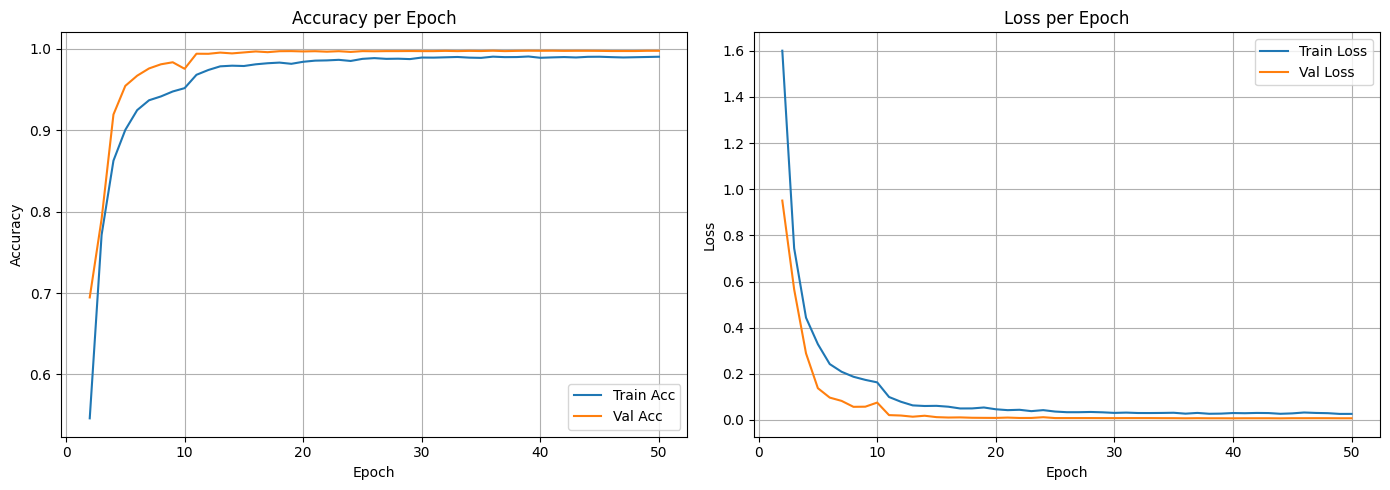

In [32]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
